In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

In [3]:
import sys
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))

In [11]:
from infino import cibersort_data, plot_dataset, plot_settings, stansummary_data

In [2]:
import re

# Table Of Contents


1. Load stansummary

2. Model convergence checks

3. Inspect trace plots

4. Other bucket estimation: is it zero? 

5. Plot mixtures
- Extend the existing violin plot, etc. to include the otherbucket estimation

- Look at correlation matrix / plot dendrogram (is the hierarchy recovered)?



# Load in stansummary

In [12]:
stan_summary_path = path.join(infino.STAN_DATA_DIR, "2.1.1stansummary_csv")

In [13]:
stan_summary = pd.read_csv(stan_summary_path, comment='#')

In [14]:
STAN_SUMMARY = pd.read_csv(stan_summary_path, comment='#')

In [15]:
stan_summary.head()

,name,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
0,lp__,2.104990e+08,335.636000,810.954000,2.104980e+08,2.104990e+08,2.105000e+08,5.83787,0.000017,1.683240e+00
1,accept_stat__,8.841480e-01,0.080600,0.202110,3.641720e-01,9.618970e-01,9.984890e-01,6.28797,0.000018,1.334990e+00
2,stepsize__,1.671840e-03,0.000360,0.000360,1.312090e-03,2.031600e-03,2.031600e-03,1.00050,0.000003,1.416670e+14
3,treedepth__,9.969000e+00,0.006561,0.293397,1.000000e+01,1.000000e+01,1.000000e+01,2000.00000,0.005778,1.021830e+00
4,n_leapfrog__,1.014300e+03,1.780540,79.628100,1.023000e+03,1.023000e+03,1.023000e+03,2000.00000,0.005778,1.023480e+00


In [8]:
# Get the parameter names 

def get_parameter_names(stan_summary):
    # Match anything to the left of a left-bracket 
    p = re.compile('([^\[]+)')

    params = list(set(stan_summary['name'][7:].str.extract(p)))
    return params

In [9]:
get_parameter_names(stan_summary)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


['sample2_x',
 'y_rep',
 'theta_coefs_per_gene',
 'Omega',
 'other_log_contribution_per_gene',
 'Omega_sigma',
 'Omega_L',
 'theta_mu',
 'gene_phi',
 'log_gene_base',
 'theta',
 'theta_coefs',
 'tau',
 'theta_coefs_raw',
 'unknown_prop',
 'log_lik']

In [10]:
def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

In [11]:
# Plot Rhat for parameter of interest 
def plot_stan_summary_metric(stan_summary, metric, parameter, title=None, figure_save_path=None):
    f = plt.figure()
    sns.distplot(stan_summary[stan_summary.name.str.startswith(parameter)][metric])
    if title is None:
        plt.title('{} metric of convergence: {}'.format(metric, parameter))
    else:
        plt.title(title)        
        
    plt.ylabel('Frequency')
    plt.xlabel(metric)
    
    if figure_save_path is not None:
        savefig(f, figure_save_path, dpi=300)

In [12]:
import itertools

# Validation of model convergence

#### R Hat

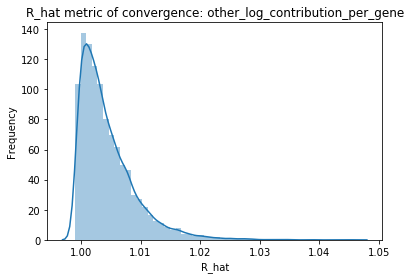

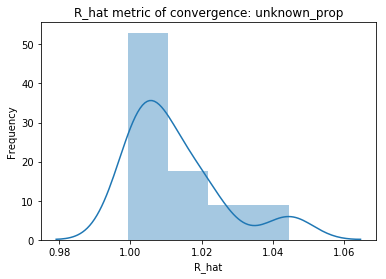

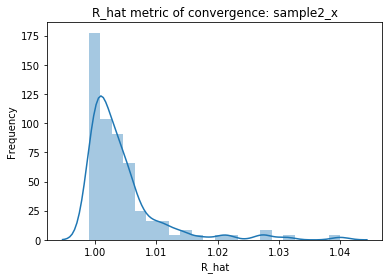

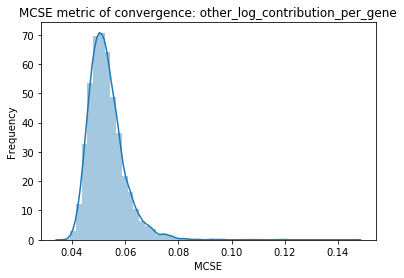

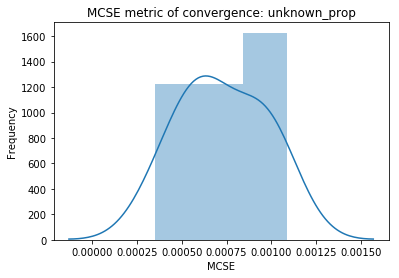

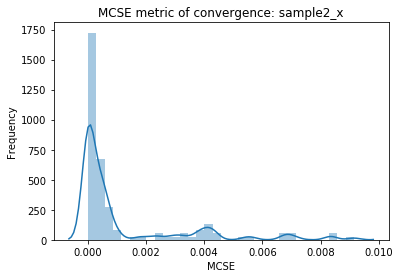

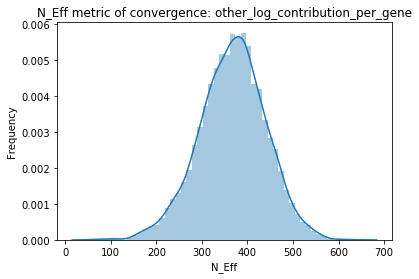

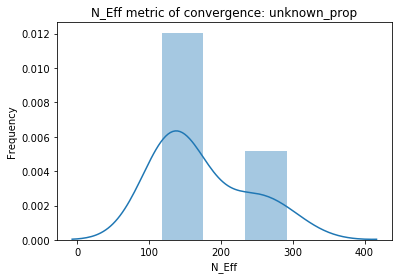

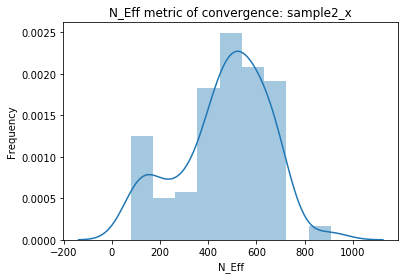

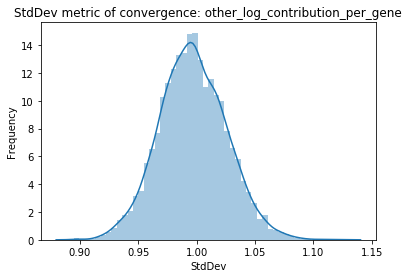

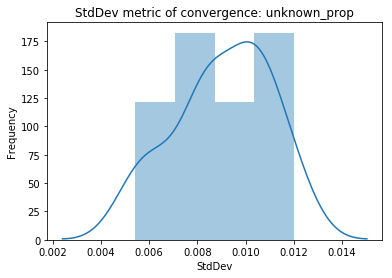

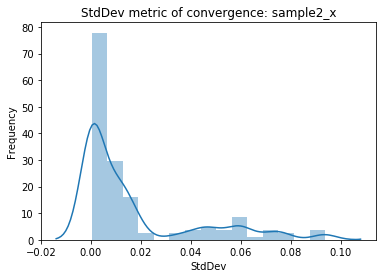

In [13]:
metrics = ["R_hat", "MCSE", "N_Eff", 'StdDev']
parameters = ["other_log_contribution_per_gene", "unknown_prop", "sample2_x"]


for metric, parameter in itertools.product(metrics, parameters) :
    plot_stan_summary_metric(stan_summary, metric=metric, parameter=parameter)

#### MCSE

Monte Carlo error is an estimate of the uncertainty contributed by only having a finite number of posterior draws. Typically we’d want roughly less than 5% of the posterior standard deviation (reported right next to it in the Stan output), but might as well go for less than 1%. With no autocorrelation it would equal 

$$\sqrt{\frac{var(\theta)}{n_eff}}$$

count    7980.000000
mean        0.053098
std         0.006260
min         0.039344
25%         0.049047
50%         0.052007
75%         0.055865
max         0.137965
dtype: float64
count    10.000000
mean      0.078898
std       0.012261
min       0.058538
25%       0.068283
50%       0.082324
75%       0.088271
max       0.092248
dtype: float64
count    130.000000
mean       0.051134
std        0.016958
min        0.033157
25%        0.040645
50%        0.044756
75%        0.052527
max        0.114029
dtype: float64


[None, None, None]

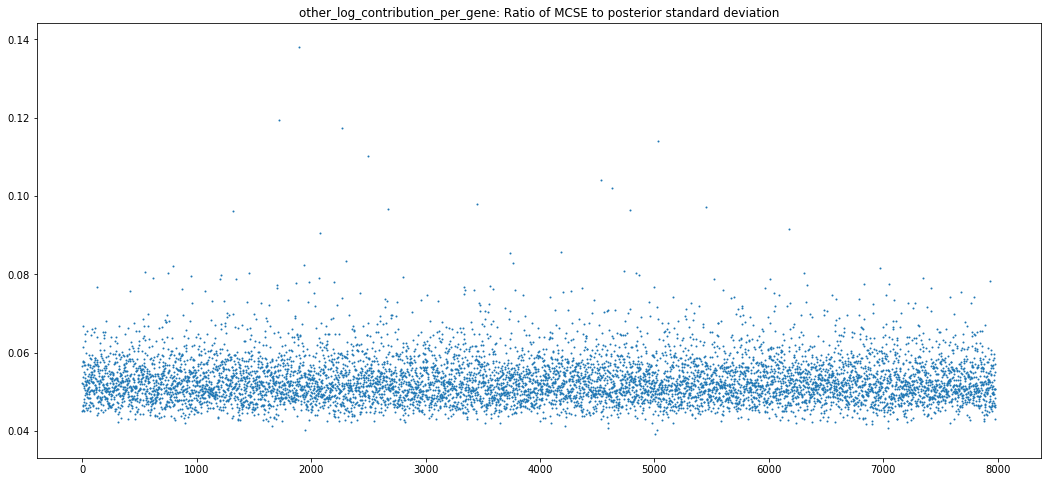

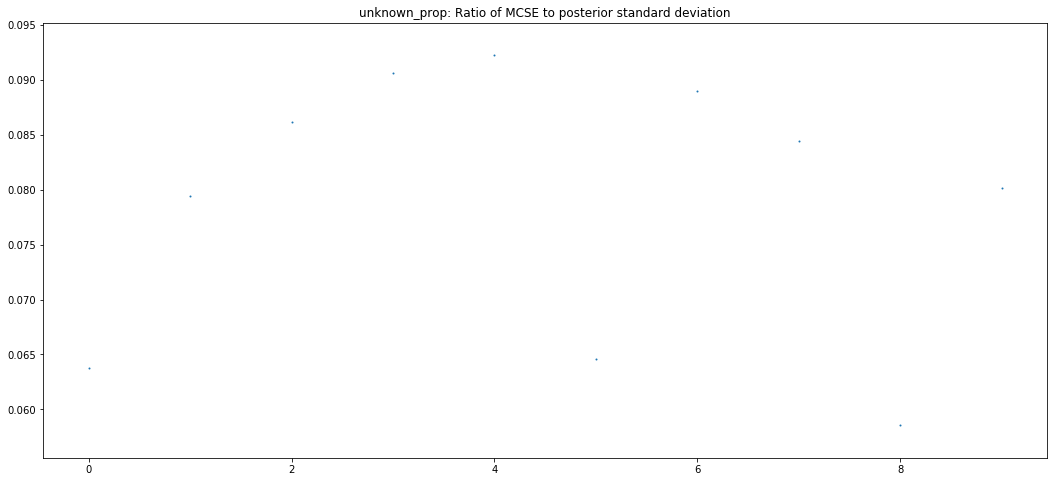

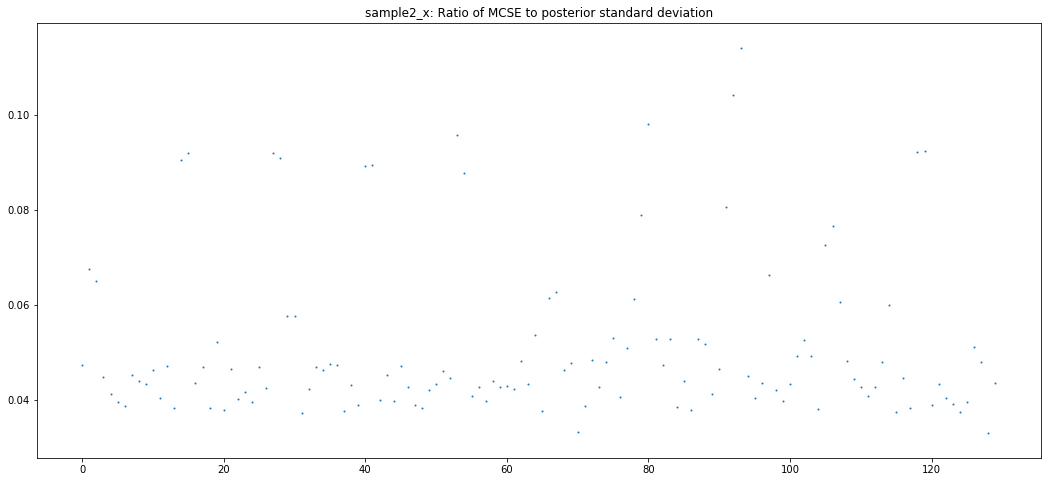

In [14]:
### Look at MCSE relative to StdDev "other_log_contribution_per_gene"

def analyze_mcse(stan_summary, parameter_name):
    parameter_df = stan_summary[stan_summary.name.str.startswith(parameter_name)]

    ratio = parameter_df['MCSE'] / parameter_df['StdDev']
    print(ratio.describe())

    f = plt.figure(figsize=(18,8))
    plt.scatter(x=range(len(ratio)), y=ratio, s=1)
    plt.title("%s: Ratio of MCSE to posterior standard deviation" % parameter_name)

[analyze_mcse(stan_summary, parameter) for parameter in parameters]



n_eff: effective sample size given all chains & essentially accounts for autocorrelation in the chain; i.e. the correlation of the estimates as we go from one draw to the next. 

R_hat: measure of how well the chains mix, and goes ot 1 as chains are allowed to run for an infinite number of draws. Seems like we have good convergence

In [15]:
stan_summary[stan_summary.name.str.startswith(parameters[0])]

,name,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
28292,"other_log_contribution_per_gene[1,1]",0.011576,0.060528,1.067850,-1.66693,-0.014425,1.76476,311.247,0.000899,1.000600
28293,"other_log_contribution_per_gene[1,2]",0.128108,0.042379,0.939760,-1.44803,0.107060,1.70945,491.738,0.001421,1.009090
28294,"other_log_contribution_per_gene[1,3]",-0.015378,0.053625,1.024480,-1.69852,-0.000532,1.66118,364.990,0.001054,1.006160
28295,"other_log_contribution_per_gene[1,4]",-0.048924,0.054317,1.009360,-1.61641,-0.089196,1.70448,345.327,0.000998,1.006610
28296,"other_log_contribution_per_gene[1,5]",-0.078623,0.046730,1.001500,-1.72640,-0.073870,1.53422,459.326,0.001327,1.000650
28297,"other_log_contribution_per_gene[1,6]",0.010734,0.052873,1.017040,-1.66093,0.032073,1.60582,370.004,0.001069,1.003200
28298,"other_log_contribution_per_gene[1,7]",0.063824,0.069845,1.047270,-1.77719,0.098989,1.69713,224.826,0.000649,1.004500
28299,"other_log_contribution_per_gene[1,8]",-0.024815,0.043894,0.969682,-1.61196,-0.053721,1.58492,488.028,0.001410,1.000590
28300,"other_log_contribution_per_gene[1,9]",-0.067487,0.056320,0.979706,-1.65287,-0.092050,1.49002,302.596,0.000874,1.005780
28301,"other_log_contribution_per_gene[1,10]",-0.020147,0.056927,0.981955,-1.64201,-0.016599,1.63829,297.543,0.000860,1.001910


# Unknown proportion estimates

```log_expected_rate = log_gene_base + log(theta*sample2_x[s]) * (1 - unknown_prop[s]) + 
                        other_log_contribution_per_gene[s] * unknown_prop[s]```


In [16]:
unknown_prop_df = stan_summary[stan_summary.name.str.startswith("unknown_prop")]

In [17]:
stan_summary[stan_summary.name.str.startswith("log_gene_base")]

,name,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
26556,log_gene_base[1],1.702190,0.024867,0.237894,1.320980,1.698390,2.103910,91.52310,0.000264,1.03616
26557,log_gene_base[2],1.260340,0.063624,0.350218,0.655321,1.254960,1.852210,30.29970,0.000088,1.06049
26558,log_gene_base[3],-0.156450,0.133098,0.302327,-0.679981,-0.162651,0.355743,5.15953,0.000015,1.09160
26559,log_gene_base[4],2.974870,0.041411,0.248158,2.587150,2.953260,3.409400,35.91140,0.000104,1.03995
26560,log_gene_base[5],2.076860,0.036666,0.227444,1.738100,2.054920,2.474430,38.47900,0.000111,1.00568
26561,log_gene_base[6],-3.557940,0.163185,1.371720,-5.040540,-4.021400,-0.616139,70.66030,0.000204,1.03740
26562,log_gene_base[7],-0.780246,0.144709,0.312501,-1.268680,-0.787760,-0.227509,4.66352,0.000013,1.12203
26563,log_gene_base[8],-3.681980,0.047387,0.496172,-4.450810,-3.686150,-2.806850,109.63400,0.000317,1.01932
26564,log_gene_base[9],-1.133900,0.056397,0.438834,-1.856030,-1.125950,-0.388686,60.54570,0.000175,1.01105
26565,log_gene_base[10],0.513386,0.045104,0.274367,0.068503,0.513503,0.978755,37.00290,0.000107,1.02520


In [18]:
stan_summary[stan_summary.name.str.startswith("Omega_L")]

,name,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
7,"Omega_L[1,1]",1.000000,1.489890e-17,6.663000e-16,1.000000,1.000000,1.000000,2000.00000,0.005778,0.998999
8,"Omega_L[1,2]",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2000.00000,0.005778,NaN
9,"Omega_L[1,3]",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2000.00000,0.005778,NaN
10,"Omega_L[1,4]",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2000.00000,0.005778,NaN
11,"Omega_L[1,5]",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2000.00000,0.005778,NaN
12,"Omega_L[1,6]",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2000.00000,0.005778,NaN
13,"Omega_L[1,7]",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2000.00000,0.005778,NaN
14,"Omega_L[1,8]",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2000.00000,0.005778,NaN
15,"Omega_L[1,9]",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2000.00000,0.005778,NaN
16,"Omega_L[1,10]",0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2000.00000,0.005778,NaN


In [19]:
unknown_prop_df['Mean']

28282    0.047806
28283    0.020762
28284    0.044601
28285    0.035744
28286    0.059887
28287    0.012065
28288    0.047538
28289    0.021808
28290    0.027718
28291    0.029667
Name: Mean, dtype: float64

In [20]:
import sys 
from os import getcwd, path, listdir
sys.path.append(path.dirname(getcwd()))

In [21]:
%load_ext autoreload
%autoreload 2

# Mixture plots

### Plot MCMC areas

C

```
log_expected_rate = log_gene_base + log(theta*sample2_x[s]) * (1 - unknown_prop[s]) + 
                        other_log_contribution_per_gene[s] * unknown_prop[s]
                        
sample2_y[s] ~ neg_binomial_2_log(log_expected_rate, gene_phi)
```

In [22]:
otherbucket_params = ['log_gene_base', 'theta[', 'sample2_x', 'unknown_prop', 'other_log_contribution_per_gene']

for p in otherbucket_params:
    try: 
        df = stan_summary[stan_summary.name.str.startswith(p)]
        print(p)
        print(len(df))
        if df is None:
            print(p)
    except Exception as e:
        print("hit exception")
        print(e)
        print(p)
        
                      

log_gene_base
798
theta[
10374
sample2_x
130
unknown_prop
10
other_log_contribution_per_gene
7980


In [23]:
def get_parameter_stan_summary(parameter, stan_summary=STAN_SUMMARY):
    return stan_summary[stan_summary.name.str.startswith(parameter)]
    

In [24]:

# sample2_x : the 13 immune cell subtypes
sample2_x_df = stan_summary[stan_summary.name.str.startswith('sample2_x')]

In [25]:
### Let's do this simply first: get the mean & stdev of the posterior for each immune cell subtype



# Load traces / trace plots

The output is `merged_samples`


In [28]:
from stansummary_data import get_trace_columns

In [93]:
USE_UNKNOWN = False

In [95]:
trace_columns = get_trace_columns('sample2_x', STAN_SUMMARY)

CELL_TYPES = ['B_CD5', 'B_Memory', 'B_Naive', 'CD4_Central_Memory',
       'CD4_Effector_Memory', 'CD4_Naive', 'CD4_Th1', 'CD4_Th17',
       'CD4_Th2', 'CD4_Treg', 'CD8_Central_Memory', 'CD8_Effector',
       'CD8_Naive']

ROLLUPS = {
    'B': [c for c in CELL_TYPES if c.startswith('B_')],
    'CD4 T': [c for c in CELL_TYPES if c.startswith('CD4_')],
    'CD8 T': [c for c in CELL_TYPES if c.startswith('CD8_')]
}


if USE_UNKNOWN:
    trace_columns.extend(get_trace_columns('unknown_prop', STAN_SUMMARY))
    CELL_TYPES.append('unknown_prop')
    ROLLUPS['UNKOWN'] = [c for c in CELL_TYPES if c.startswith('unknown_prop')]

In [30]:
trace_filenames_list = [
    "/modelcache/experiments/20171106_6.4otherbucket/2.1.1_samples1.csv", 
    "/modelcache/experiments/20171106_6.4otherbucket/2.1.1_samples2.csv",
    "/modelcache/experiments/20171106_6.4otherbucket/2.1.1_samples3.csv",
    "/modelcache/experiments/20171106_6.4otherbucket/2.1.1_samples1.csv"
]

In [31]:
### 2.1.1_samples1.csv:#     num_warmup = 1000 (Default)
### 2.1.1_samples1.csv:#     save_warmup = 0 (Default)
warmup=0 

In [96]:
all_traces_df = get_all_traces_df(trace_filenames_list, 
                      trace_columns)

In [63]:
#all_traces_df2 = pd.melt(all_traces_df, id_vars=['iter','trace_id'], value_name='estimate', var_name='variable')



In [97]:
all_traces_df2 = pd.melt(all_traces_df, id_vars=['iter','trace_id'], value_name='estimate', var_name='variable')
var_ids = all_traces_df2.variable.str.extract('sample2_x.(?P<sample_id>\d+).(?P<subset_id>\d+)')

all_traces_df3= pd.concat([all_traces_df2, var_ids], axis=1) 
all_traces_df3['subset_id'] = all_traces_df3['subset_id'].astype(int)
all_traces_df3['sample_id'] = all_traces_df3['sample_id'].astype(int)

sample2_xs = stan_summary[stan_summary['name'].str.startswith('sample2_x')]['Mean'].values.reshape(all_traces_df3.sample_id.max(), all_traces_df3.subset_id.max()) # (10,13) before



/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [106]:
cell_types = CELL_TYPES
rollups = ROLLUPS

In [104]:
def label_rollup(rollups, x):
    for key in rollups.keys():
        if x in rollups[key]:
            return key
    return None

In [107]:
mixture_estimates = pd.DataFrame(sample2_xs, columns=cell_types)

subset_names = [re.sub(string=x, pattern='(.*)\[(.*)\]', repl='\\2') for x in mixture_estimates.columns]

all_traces_df3['subset_name'] = all_traces_df3.subset_id.apply(lambda i: subset_names[i-1])

num_samples = all_traces_df3.iter.max() + 1

# combine iteration numbers across traces -- i.e. line them up from 0 to 4000, not 4 versions of 0 to 1000
#(all_traces_df3['trace_id']*1000 + all_traces_df3['iter']).hist()
(all_traces_df3['trace_id']*num_samples + all_traces_df3['iter']).describe()[['min', 'max']]

all_traces_df3['combined_iter_number'] = (all_traces_df3['trace_id']*num_samples + all_traces_df3['iter'])

assert all_traces_df3.shape[0] / all_traces_df3.sample_id.max() / all_traces_df3.subset_id.max() / 4 == num_samples

# Add rollup column

all_traces_df3['rollup'] = all_traces_df3.subset_name.apply(lambda x: label_rollup(rollups, x))

samples_rolledup = all_traces_df3.groupby(['sample_id', 'combined_iter_number', 'rollup']).estimate.sum().reset_index()

cleaner_traces = all_traces_df3.copy()
cleaner_traces['subset_name'] = cleaner_traces['subset_name'].str.replace('_', ' ')

merged_samples_1 = cleaner_traces[['sample_id', 'combined_iter_number', 'subset_name', 'estimate']].copy()
merged_samples_1['type'] = 'subset'
merged_samples_2 = samples_rolledup.copy()
merged_samples_2.columns = [c.replace('rollup', 'subset_name') for c in merged_samples_2.columns]
merged_samples_2['type'] = 'rollup'
merged_samples = pd.concat([merged_samples_1, merged_samples_2])

In [109]:
all_traces_df

,sample2_x.1.1,sample2_x.2.1,sample2_x.3.1,sample2_x.4.1,sample2_x.5.1,sample2_x.6.1,sample2_x.7.1,sample2_x.8.1,sample2_x.9.1,sample2_x.10.1,...,sample2_x.3.13,sample2_x.4.13,sample2_x.5.13,sample2_x.6.13,sample2_x.7.13,sample2_x.8.13,sample2_x.9.13,sample2_x.10.13,trace_id,iter
0,0.001896,0.032043,0.011270,0.015482,0.017876,0.003302,0.179600,0.043743,0.022564,0.003225,...,0.000552,0.000653,0.001385,0.000095,0.006882,0.005906,0.000987,0.009201,0,0
1,0.002584,0.025531,0.007016,0.015624,0.043004,0.007536,0.273445,0.021043,0.013074,0.001532,...,0.000416,0.000924,0.001039,0.000198,0.002049,0.010463,0.003786,0.014872,0,1
2,0.069244,0.017225,0.022163,0.035105,0.034852,0.019347,0.281465,0.015172,0.003785,0.020894,...,0.000164,0.001665,0.000635,0.000286,0.002218,0.017134,0.002002,0.000962,0,2
3,0.026420,0.017881,0.021213,0.018566,0.034351,0.033178,0.266450,0.018043,0.005038,0.016645,...,0.000225,0.001392,0.000502,0.000192,0.001226,0.015768,0.002492,0.001731,0,3
4,0.027511,0.017106,0.022261,0.017990,0.038423,0.038019,0.269159,0.017424,0.004762,0.017186,...,0.000218,0.001379,0.000534,0.000210,0.001445,0.015172,0.002426,0.001849,0,4
5,0.023582,0.018886,0.018623,0.015885,0.027182,0.034339,0.197192,0.020678,0.005838,0.010589,...,0.000195,0.001159,0.000273,0.000297,0.001103,0.019480,0.002451,0.000625,0,5
6,0.023209,0.012233,0.009354,0.009942,0.027987,0.011399,0.195782,0.018003,0.011727,0.008465,...,0.000570,0.000770,0.000318,0.000635,0.000375,0.019401,0.002223,0.000249,0,6
7,0.013159,0.016518,0.010029,0.007511,0.021071,0.004977,0.148496,0.048264,0.022238,0.008736,...,0.000182,0.000106,0.000323,0.000870,0.000215,0.026429,0.000379,0.000903,0,7
8,0.003401,0.022142,0.008239,0.011266,0.021628,0.007194,0.127387,0.032224,0.024329,0.007630,...,0.000236,0.000258,0.000338,0.000175,0.000541,0.029707,0.000685,0.001154,0,8
9,0.008690,0.032283,0.004854,0.050456,0.021666,0.011853,0.075053,0.061214,0.016076,0.005286,...,0.000109,0.000277,0.000727,0.000373,0.001326,0.026779,0.002162,0.000644,0,9


In [110]:
merged_samples

,sample_id,combined_iter_number,subset_name,estimate,type
0,1,0,B CD5,0.001896,subset
1,1,1,B CD5,0.002584,subset
2,1,2,B CD5,0.069244,subset
3,1,3,B CD5,0.026420,subset
4,1,4,B CD5,0.027511,subset
5,1,5,B CD5,0.023582,subset
6,1,6,B CD5,0.023209,subset
7,1,7,B CD5,0.013159,subset
8,1,8,B CD5,0.003401,subset
9,1,9,B CD5,0.008690,subset


## Load trace data for unknown prop

In [111]:
unknown_trace_columns = get_trace_columns('unknown_prop', STAN_SUMMARY)


In [114]:
unknowns_trace_df = get_all_traces_df(trace_filenames_list, unknown_trace_columns)

In [115]:
unknowns_trace_df

,unknown_prop.1,unknown_prop.2,unknown_prop.3,unknown_prop.4,unknown_prop.5,unknown_prop.6,unknown_prop.7,unknown_prop.8,unknown_prop.9,unknown_prop.10,trace_id,iter
0,0.044258,0.022931,0.027923,0.061608,0.048560,0.015661,0.054886,0.020484,0.021816,0.009539,0,0
1,0.039255,0.017907,0.021877,0.055012,0.046040,0.015904,0.063968,0.019936,0.022385,0.008206,0,1
2,0.035993,0.017065,0.022310,0.046598,0.062292,0.011523,0.055216,0.022019,0.016716,0.009149,0,2
3,0.038652,0.020686,0.021364,0.041398,0.059728,0.009914,0.055105,0.022001,0.017060,0.010668,0,3
4,0.038683,0.020022,0.021243,0.041936,0.059766,0.009929,0.055335,0.022452,0.017136,0.010804,0,4
5,0.036983,0.019767,0.022054,0.036195,0.064801,0.010197,0.061789,0.021635,0.017744,0.011688,0,5
6,0.036537,0.019590,0.022116,0.033281,0.067297,0.008683,0.054763,0.032850,0.011001,0.012601,0,6
7,0.036478,0.019317,0.020123,0.031407,0.064290,0.012283,0.063973,0.027828,0.009979,0.014498,0,7
8,0.038317,0.021894,0.020337,0.033104,0.062228,0.013741,0.071419,0.027945,0.010841,0.014874,0,8
9,0.042870,0.018449,0.020396,0.035914,0.060737,0.011847,0.067621,0.025985,0.010834,0.015537,0,9


In [116]:
df2 = pd.melt(unknowns_trace_df, id_vars=['iter','trace_id'], value_name='estimate', var_name='variable')


In [127]:
all_traces_df3['combined_iter_number'] = all_traces_df3['iter'] + all_traces_df3['trace_id']*1000

In [129]:
all_traces_df3['subset_name'] = pd.Series(['Unknown']*len(all_traces_df3))

In [132]:
all_traces_df3['type'] = all_traces_df3['subset_name']

In [133]:
unknowns_merged_samples = all_traces_df3[['sample_id', 'combined_iter_number', 'subset_name', 'estimate', 'type']]

In [134]:

all_merged_samples = pd.concat([merged_samples, unknowns_merged_samples])

In [16]:
all_merged_samples

NameError: name 'all_merged_samples' is not defined

#### Workflow

In [138]:
from cibersort_data import *

In [140]:
cibersort_df = get_cibersort_df("infino-rcc/all_cohorts.cibersort_results.tsv")

In [142]:
set(cibersort_df.cohort)

{'newbladder', 'tcgakirc'}

In [141]:
cibersort_df

,Column,B_CD5,B_Memory,B_Naive,CD4_Central_Memory,CD4_Effector_Memory,CD4_Naive,CD4_Th1,CD4_Th17,CD4_Th2,...,P-value,Pearson Correlation,RMSE,cohort,metric,processing,data_col,cohort_sample_id,incut_sample_id,cutname
0,0,0.345292,0.109462,0.000000,0.000000,0.000000,0.000000,0.402326,0.000000,0.052995,...,0.09,0.257156,1.036539,tcgakirc,counts,raw,est_counts,1,1,cut1
1,1,0.190512,0.338138,0.000000,0.118218,0.000000,0.155444,0.000000,0.040930,0.000000,...,0.06,0.283903,1.058057,tcgakirc,counts,raw,est_counts,2,2,cut1
2,2,0.005919,0.382426,0.000000,0.000000,0.117254,0.000000,0.418500,0.000000,0.034759,...,0.09,0.271856,1.045246,tcgakirc,counts,raw,est_counts,3,3,cut1
3,3,0.131206,0.257399,0.000000,0.058128,0.045207,0.165655,0.270405,0.000000,0.010426,...,0.19,0.101305,1.144795,tcgakirc,counts,raw,est_counts,4,4,cut1
4,4,0.000000,0.431672,0.000000,0.229889,0.000000,0.000000,0.173877,0.000000,0.044422,...,0.04,0.308456,1.029479,tcgakirc,counts,raw,est_counts,5,5,cut1
5,5,0.241646,0.228902,0.000000,0.146915,0.000000,0.141131,0.000000,0.000000,0.000000,...,0.14,0.172933,1.105290,tcgakirc,counts,raw,est_counts,6,6,cut1
6,6,0.009321,0.382460,0.000000,0.000000,0.141684,0.008193,0.398687,0.000000,0.046584,...,0.09,0.274604,1.044718,tcgakirc,counts,raw,est_counts,7,7,cut1
7,7,0.203197,0.185872,0.000000,0.092901,0.000000,0.101031,0.221563,0.000000,0.098868,...,0.09,0.227219,1.057578,tcgakirc,counts,raw,est_counts,8,8,cut1
8,8,0.000000,0.303576,0.000000,0.000000,0.156842,0.000000,0.416070,0.000000,0.033332,...,0.46,0.015712,1.179152,tcgakirc,counts,raw,est_counts,9,9,cut1
9,9,0.248124,0.336558,0.000000,0.123655,0.000000,0.107503,0.000000,0.000000,0.000000,...,0.04,0.298532,1.058541,tcgakirc,counts,raw,est_counts,10,10,cut1


In [84]:
from stansummary_data import traces_to_dataset as ttd

In [ ]:
trace

merged_samples = traces_to_dataset(trace_filenames_list, 
                                   trace_columns, 
                                   warmup=0, 
                                   stan_summary=STAN_SUMMARY, 
                                   rollups=ROLLUPS, 
                                   cell_types=CELL_TYPES,
                                   logging=True
                                  )


### From `merged_samples`, plot

### For each mixture, plot the posterior distributions of `unknown_prop` and `other_log_contribution_per_gene`

How? Box plot a la `plot_single_mixture_results`? 

plot_mcmc_areas vs. plot_violins?
